# Walk through all steps used in research for chapter3

Author: CK kibet

Work has been published in Kibet CK and Machanick P. Transcription factor motif quality assessment requires systematic comparative analysis [version 2; referees: 2 approved]. F1000Research 2015, 4(ISCB Comm J):1429 (doi: 10.12688/f1000research.7408.2)

Feel free to email at calebkibet88@gmail.com for any clarity needed. 

### Updated for Chapter 3 of thesis

## Some dependencies
#### From conda:
* ipython==4.2.0
* jupyter==1.0.0
* numpy==1.10.4
* pandas==0.17.1
* scipy==0.16.0
* seaborn==0.5.1
* matplotlib==1.4.3

#### From Bioconda
* gimmemotifs==0.8.5
* pybedtools==0.7.6

#### Non-python modules

* meme v4.11.1
* bedtools v2.24.0
* homer toos: Use the tab2fasta

The raw data could not be uploaded to Github due to size. Nevertheless, we provide the code to generate the data for raw data. 

In [4]:
cd /media/Elements/PhD/Project/Motif_Assessment/PAPER_Assessment_Data/Kibet-F1000Research/code

/media/Elements/PhD/Project/Motif_Assessment/PAPER_Assessment_Data/Kibet-F1000Research/code


#### First, lets import all the base modules

In [5]:
import os
import errno
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ranksums
import random

from multiprocessing import Pool, cpu_count
import subprocess
import pandas as pd
import numpy as np
from math import  exp
import seaborn as sns
import glob
import os

import pybedtools
pd.set_option('display.max_colwidth', -1)


from tempfile import NamedTemporaryFile
import Assess_by_score_v2 as assess
%matplotlib inline

### Get global figure settings

In [142]:
sns.set(style="ticks", context="poster")

### Set path some paths

This notebook assumes that the working directory is the code folder and the other folders are located one folder back

In [14]:
##Fgures
figure_path = "/media/Elements/PhD/Project/Motif_Assessment/PAPER_Assessment_Data/MARS_Evaluation/Chapter3/Figs"
figure_path = "/home/kipkurui/Dropbox/PHD/Documents/Phd_Thesis/Chapter3/Figs" #"../Figures"
downloaded_peaks = "/home/kipkurui/Project/MARS/Data/ChIP-seq/Downloaded" #raw peaks from 
hg = "/home/kipkurui/Project/MARS/Data/hg19.fa"

### Calculate statistical significance and effect size

In [7]:
def get_stat_wilcoxon_effect_size(sample1,sample2):
    X1 = np.array(sample1)
    X2 = np.array(sample2)
    n1 = len(sample1)
    n2 = len(sample2)
    m1 = np.mean(X1)
    m2 = np.mean(X2)
    s1 = np.std(X1,ddof=1)
    s2 = np.std(X2,ddof=1)

    s = np.sqrt( ((n1-1)*s1**2 + (n2-1)*s2**2)/(n1+n2) )
    return ranksums(sample1,sample2)[1],(m2-m1)/s

### Convert the ENCODE data into posneg format

posneg is a format we just made up to represent the test file as follows: 

    chromosome:start-end score sequence eg

    chr19:10828427-10828527	486.128011369018 TCTACTGGCACGTCTGCCTGCCAATAAGAT
    
To convert to this format, the following are required:

1. A human genome file in Hg19 format that has been repeat-masked with NNs
2. MEME fastafrombed script--just get complete meme tools, you'll need them later
3. RAW ChIP-seq peaks: http://hgdownload.cse.ucsc.edu/goldenPath/hg19/encodeDCC/wgEncodeAwgTfbsUniform/

A script to execute the whole process is provided.

### List of TFs meeting criteria

List of TFs meeting criteria of having ChIP-seq data and more than 10 motifs

In [135]:
tf_list = ['cebpb', 'ctcf', 'egr1', 'elf1', 'ets1', 'foxa', 'gata3',
 'hnf4a', 'mafk', 'max', 'mef2a', 'myb', 'nrf1', 'pax5', 'pou2f2',
 'prdm1', 'sp1', 'srf', 'tcf3', 'yy1']

### Effect of ChIP-seq length in motif Ranking

This requires TFBS peaks from ENCODE to extract the sequences

In [10]:
len_dic = {"At_50":50,"At_100":100,"At_250":250}

In [430]:
for length in "At_50 At_100 At_250".split():
    width = len_dic[length]
    
    for tf in tf_list:
        max_ch = glob.glob("%s/*%s*" % (downloaded_peaks,tf.capitalize()))
        if len(max_ch) > 15:
            random.seed(10)
            max_ch = random.sample(max_ch, 15)
        for peak in max_ch:
            pybedtools.cleanup()
            combined_bed = get_flanking_background(peak, width, 500)
            #combined_bed = get_background(peak,width,neg_type)
            f_name = peak.split("/")[-1].split("wgEncodeAwgTfbs")[-1].split("UniPk.narrowPeak")[0] + ".posneg"

            save_neg = "../Length/%s/Data/%s" % (length,tf.lower())
            mkdir_p(save_neg)

            pybedtools.BedTool.from_dataframe(combined_bed).sequence(fi=hg,tab=True).save_seqs("%s/%s" % (save_neg,f_name))

#### Run the analysis

Rank motifs using sequences of the different lengths. 

In [572]:
for neg_type in ["At_100 At_50 At_250".split():#"promoter gc flanking dinuc_shuffled".split():
    for tf in tf_list:
        results_path = '../Length/%s/Results/%s' % (neg_type,tf.lower())
        mkdir_p(results_path)

        chip_seq_list = glob.glob('../Length/%s/Data/%s/*' % (neg_type,tf.lower()))
        
        for key in "gomeroccupancyscore energyscore".split():
            assess.run_all(tf, key, '%s/Motifs/%s.meme' %(BASE_DIR, tf), chip_seq_list, results_path)

#### Summarize the results 

Now we can summarize the results for plotting. 

In [11]:
key = "gomer"
combined_tfs_corr = pd.DataFrame()
combined_tfs_mean = pd.DataFrame()
for tf in tf_list:
    #print tf
    combined_gomer_auc = pd.DataFrame()
    for neg_type in "At_50 At_100 At_250".split():
        results_path = '../Length/%s/Results/%s' % (neg_type,tf.lower())
        test = pd.read_table('%s/%s.%s' % (results_path,tf,key))
        combined_gomer_auc[neg_type] = test["AUC"]
    #print combined_gomer_auc.corr().mean()
    combined_tfs_corr[tf] = combined_gomer_auc.corr(method="spearman").mean()
    combined_tfs_mean[tf] = combined_gomer_auc.median()

In [12]:
al_list = ["Tf At_50 At_100 At_250".split()]
sns.set(style="white", context="paper")
key = "gomer"
#combined_tfs_corr = pd.DataFrame()
#combined_tfs_mean = pd.DataFrame()
for tf in tf_list:
    #print tf
    combined_gomer_auc = pd.DataFrame()
    for neg_type in "At_50 At_100 At_250".split():
        results_path = '../Length/%s/Results/%s' % (neg_type,tf.lower())
        test = pd.read_table('%s/%s.%s' % (results_path,tf,key))
        combined_gomer_auc[neg_type] = test["AUC"]
    new_l = [tf]
    for neg_type in "At_50 At_100 At_250".split():
        #print neg_type
        #for neg in "genomic promoter gc flanking dinuc_shuffled".split():
        new_l.append(get_stat_wilcoxon_effect_size(combined_gomer_auc[neg_type],combined_gomer_auc["At_100"])[0])
    al_list.append(new_l[:])

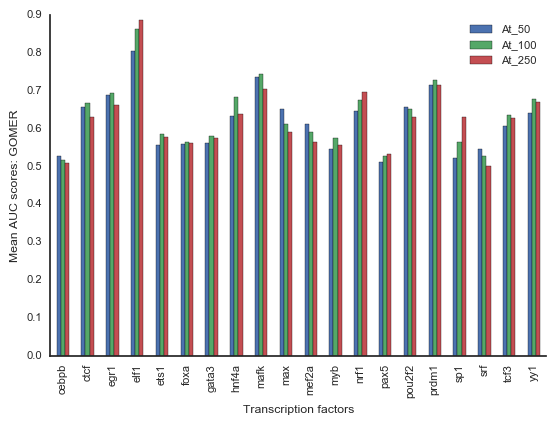

In [13]:
combined_tfs_mean.T.plot.bar()
plt.ylabel("Mean AUC scores: GOMER")
plt.xlabel("Transcription factors")
sns.despine()
plt.savefig("%s/Effect_of_length_gomer_auc.pdf" % figure_path, bbox_inches='tight')

### Figure 3.3. Sequence length has no significant effect in motif ranking

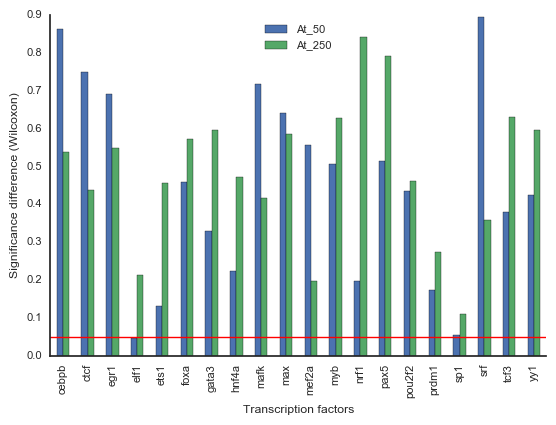

In [14]:
test = pd.DataFrame(al_list)
test.set_index(0, inplace=True)
new_header = test.iloc[0] #grab the first row for the header
test = test[1:] #take the data less the header row
test = test.rename(columns = new_header) 
del test["At_100"]

sns.set(style="white", context="paper")
test.plot.bar(stacked=False)
plt.axhline(0.05, linewidth=1, color='r')
plt.ylabel("Significance difference (Wilcoxon)")
plt.xlabel("Transcription factors")
sns.despine()
plt.savefig("%s/Effect_of_length_gomer_100_auc_wilcoxon.pdf" % figure_path, bbox_inches='tight')

### Function to extract background sequences

In [136]:
def get_flanking_background(peak, width, downstream_distance):
    """
    Given a bed file, extract the fasta in tab format and eliminate the masked sequences,
    and extract the negative version of the file
    
    """
    #Read the narrow peak file into a pandas DataFrame
    
    peak_file = pd.read_table(peak, header=None)[[0,1,2]]
    
    size = peak_file.count()[0]
    if size/20 >500:
        use_size = size/20
    else:
        use_size = 500
    
    peak_file = peak_file.head(use_size*2)
    
    #Lets widden the coordinates to 100bp centered around the center
    mid = (peak_file[2] + peak_file[1])/2
    peak_file[1] = (mid - width/2+0.5).apply(int)
    peak_file[2]  = (mid + width/2+0.5).apply(int)
    
    #Extract the negative set located 500bp downstream
    neg_bed = peak_file.copy(deep=True)
    
    neg_bed[1] = neg_bed[1]+downstream_distance
    neg_bed[2] = neg_bed[2]+downstream_distance
    
    # Eliminate repeat masked regions from the bed file
    peak_file = remove_repeats(peak_file) #.to_csv(pos_bed_out, index=None, header=None, sep="\t")
    neg_bed = remove_repeats(neg_bed) #.to_csv(neg_bed_out, index=None, header=None, sep="\t")
    
    #return peak_file, neg_bed
    
    combined_bed = peak_file.head(use_size).append(neg_bed.head(use_size))
    combined_bed.reset_index(drop=True, inplace=True)
    return combined_bed
    #pybedtools.BedTool.from_dataframe(peak_file).sequence(fi=hg,).save_seqs(negfa_out)

def remove_repeats(dfs):
    """
    Takes a bed file dataframe and eliminated bed
    coordinates that fall within the repeat masked sections
    """
    repeats = pd.read_table("/home/kipkurui/Downloads/repeat_sites.bed", header=None)
    repeats = pybedtools.BedTool.from_dataframe(repeats)
#     if len(dfs) > 2000:
#         get_top = 2000
#     else:
#         get_top = len(dfs)
    a = pybedtools.BedTool.from_dataframe(dfs)
    
    test = a.subtract(repeats, A=True)
    
    return test.to_dataframe()

### Effect of background sequence on motif ranking

In [15]:
peak = "../ChIP_seq/Data/Derived/BroadDnd41Ctcf-tmp.bed"

width = 100
neg_type = "genomic"

def get_background(peak,width,neg_type):
    """
    TODO: Ensure that it can adapt to fewer sequences gracefully
    """
    peak_file = pd.read_table(peak, header=None)[[0,1,2]]
    size = peak_file.count()[0]
    
    if size/20 >500:
        use_size = size/20
    else:
        use_size = 500
    peak_file = peak_file.head(use_size*2)
    
    mid = (peak_file[2] + peak_file[1])/2
    peak_file[1] = (mid - width/2+0.5).apply(int)
    peak_file[2]  = (mid + width/2+0.5).apply(int)

    peak_file = remove_repeats(peak_file)

    tempbed_pos = NamedTemporaryFile(dir=mytmpdir).name
    tempbed_neg_genomic = NamedTemporaryFile(dir=mytmpdir).name
    peak_file.to_csv(tempbed_pos,sep="\t",header=False, index=False)

    !gimme background -i {tempbed_pos} -f BED -l {width} -n {use_size*4} -g hg19 {tempbed_neg_genomic} {neg_type}
    
    tempbed_neg_genomic_bed = pd.read_table(tempbed_neg_genomic, header=None)[[0,1,2]]
    tempbed_neg_genomic_bed = remove_repeats(tempbed_neg_genomic_bed)
    
    combined_bed = peak_file.head(use_size).append(tempbed_neg_genomic_bed.head(use_size))
    combined_bed.reset_index(drop=True, inplace=True)
    
    os.remove(tempbed_pos)
    os.remove(tempbed_neg_genomic)
    
    return combined_bed
    

In [226]:
tf_list.pop(tf_list.index("ctcf"))
tf_list.pop(tf_list.index("cebpb"))

'cebpb'

### GC matched to postive sequences

In [1]:
width = 100
neg_type = "gc"
for neg_type in ["gc"]:#.split():
    for tf in tf_list:
        max_ch = glob.glob("%s/*%s*" % (downloaded_peaks,tf.capitalize()))
        for peak in max_ch:
            pybedtools.cleanup()
            combined_bed = get_background(peak,width,neg_type)
            f_name = peak.split("/")[-1].split("wgEncodeAwgTfbs")[-1].split("UniPk.narrowPeak")[0] + ".posneg"

            #hg = "/home/kipkurui/Project/MARS/Data/hg19.fa"
            save_neg = "../background/%s/Data/%s" % (neg_type,tf.lower())
            mkdir_p(save_neg)

            pybedtools.BedTool.from_dataframe(combined_bed).sequence(fi=hg,tab=True).save_seqs("%s/%s" % (save_neg,f_name))

### Extract flanking sequences

In [224]:
width = 100
neg_type = "flanking"
for tf in tf_list:
    max_ch = glob.glob("%s/*%s*" % (downloaded_peaks,tf.capitalize()))
    for peak in max_ch:
        pybedtools.cleanup()
        combined_bed = get_flanking_background(peak, width, 500)
        #combined_bed = get_background(peak,width,neg_type)
        f_name = peak.split("/")[-1].split("wgEncodeAwgTfbs")[-1].split("UniPk.narrowPeak")[0] + ".posneg"

        save_neg = "../background/%s/Data/%s" % (neg_type,tf.lower())
        mkdir_p(save_neg)

        pybedtools.BedTool.from_dataframe(combined_bed).sequence(fi=hg,tab=True).save_seqs("%s/%s" % (save_neg,f_name))

### Extract dinucleotide shuffle sequences

In [2]:
width = 100
neg_type = "dinuc_shuffled"
for tf in tf_list:
    max_ch = glob.glob("%s/*%s*" % (downloaded_peaks,tf.capitalize()))
    for peak in max_ch:
        f_name = peak.split("/")[-1].split("wgEncodeAwgTfbs")[-1].split("UniPk.narrowPeak")[0] + ".posneg"

        save_neg = "../background/%s/Data/%s" % (neg_type,tf.lower())
        mkdir_p(save_neg)

        shuffle = "../background/%s/Data/%s/%s" % (neg_type,tf.lower(),f_name)
        get_sh = "../background/%s/Data/%s/%s" % ("flanking",tf.lower(),f_name)

        tmpfasta = NamedTemporaryFile(dir=mytmpdir).name
        tmpfasta2 = NamedTemporaryFile(dir=mytmpdir).name

        a = !wc -l {get_sh} |cut -f1 -d" "
        a = (int(a[0]))/2

        !head -{a} {get_sh} >{shuffle}
        !tab2fasta.pl {get_sh} >{tmpfasta}
        !fasta-dinucleotide-shuffle -f {tmpfasta} > {tmpfasta2}
        !fasta2tab.pl {tmpfasta2} | head -{a} >>{shuffle}

        os.remove(tmpfasta)
        os.remove(tmpfasta2)



#         pybedtools.BedTool.from_dataframe(combined_bed).sequence(fi=hg,tab=True).save_seqs("%s/%s" % (save_neg,f_name))

In [3]:
#combined_bed = get_flanking_background(peak, width, 500)

In [ ]:
# tempbed_neg_gc = NamedTemporaryFile(dir=mytmpdir).name
# !gimme background -i {tempbed_pos} -f BED -l 100 -n {size/10} -g hg19 {tempbed_neg_gc} gc
# tempbed_neg = NamedTemporaryFile(dir=mytmpdir).name
# !gimme background -i {tempbed_pos} -f BED -l 100 -n {size/10} -g hg19 {tempbed_neg_promoter} genomic

In [142]:
neg_type = "genomic"

In [228]:
tf_list.append("ctcf")
tf_list.append("cebpb")

### Data analysis

In [ ]:
for neg_type in ["genomic promoter gc flanking dinuc_shuffled".split():
    for tf in ["ctcf","cebpb"]:
        results_path = '../background/%s/Results/%s' % (neg_type,tf.lower())
        mkdir_p(results_path)

        chip_seq_list = glob.glob('../background/%s/Data/%s/*' % (neg_type,tf.lower()))
        
        for key in "gomeroccupancyscore energyscore".split():
            assess.run_all(tf, key, '%s/Motifs/%s.meme' %(BASE_DIR, tf), chip_seq_list, results_path)

In [292]:
combined_tfs.T.mean()

genomic           0.896703
promoter          0.847235
gc                0.864448
flanking          0.922649
dinuc_shuffled    0.891795
dtype: float64

In [17]:
key = "gomer"
combined_tfs_corr = pd.DataFrame()
combined_tfs_mean = pd.DataFrame()
for tf in tf_list:
    #print tf
    combined_gomer_auc = pd.DataFrame()
    for neg_type in "genomic promoter gc flanking dinuc_shuffled".split():
        results_path = '../background/%s/Results/%s' % (neg_type,tf.lower())
        test = pd.read_table('%s/%s.%s' % (results_path,tf,key))
        combined_gomer_auc[neg_type] = test["AUC"]
    #print combined_gomer_auc.corr().mean()
    combined_tfs_corr[tf] = combined_gomer_auc.corr(method="spearman").mean()
    combined_tfs_mean[tf] = combined_gomer_auc.median()

In [15]:
get_stat_wilcoxon_effect_size(combined_gomer_auc["genomic"],combined_gomer_auc["flanking"])

(0.095602630620163012, -0.38194667590066134)

### Calculating the significance differece in the ranks in different background sequences

In [20]:

sns.set(style="white", context="paper")
key = "gomer"
def plot_background(key,stat):
    
    al_list = ["Tf genomic promoter gc flanking dinuc_shuffled".split()]
    combined_tfs_corr = pd.DataFrame()
    combined_tfs_mean = pd.DataFrame()
    for tf in tf_list:
        #print tf
        combined_gomer_auc = pd.DataFrame()
        for neg_type in "genomic promoter gc flanking dinuc_shuffled".split():
            results_path = '../background/%s/Results/%s' % (neg_type,tf.lower())
            test = pd.read_table('%s/%s.%s' % (results_path,tf,key))
            combined_gomer_auc[neg_type] = test[stat.upper()]
        new_l = [tf]
        for neg_type in "genomic promoter gc flanking dinuc_shuffled".split():
            #print neg_type
            #for neg in "genomic promoter gc flanking dinuc_shuffled".split():
            new_l.append(get_stat_wilcoxon_effect_size(combined_gomer_auc[neg_type],combined_gomer_auc["genomic"])[0])
        al_list.append(new_l[:])

    test = pd.DataFrame(al_list)

    test.set_index(0, inplace=True)
    new_header = test.iloc[0] #grab the first row for the header
    test = test[1:] #take the data less the header row
    test = test.rename(columns = new_header) 
    del test["genomic"]


    sns.set(style="white", context="paper")
    test.plot.bar(stacked=False)
    plt.axhline(0.05, linewidth=1, color='r')
    plt.ylabel("Significance difference (Wilcoxon p-value) with %s" % key.upper())
    plt.xlabel("Transcription factors")
    if key == 'energy':
        plt.title("A. %s" % key.upper())
    else:
        plt.title("B. %s" % key.upper())
    sns.despine()
    #plt.savefig("%s/effect_of_background_%s_wilcoxon_genomic_%s_bar.png" % (figure_path,key.lower(),stat.lower()), bbox_inches='tight')
        #print combined_gomer_auc.corr().mean()
        #combined_tfs_corr[tf] = combined_gomer_auc.corr(method="spearman").mean()
        #combined_tfs_mean[tf] = combined_gomer_auc.mean()

### Figure 3:6 Plot for each of the background set

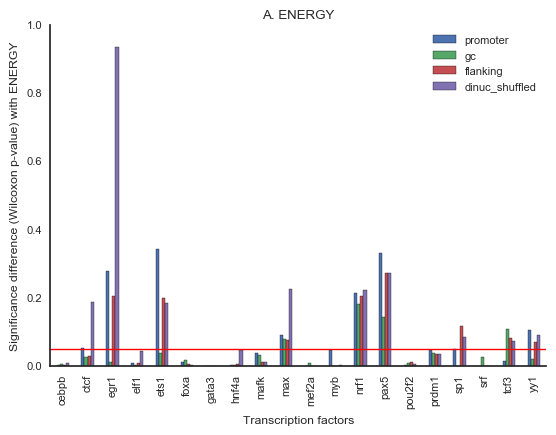

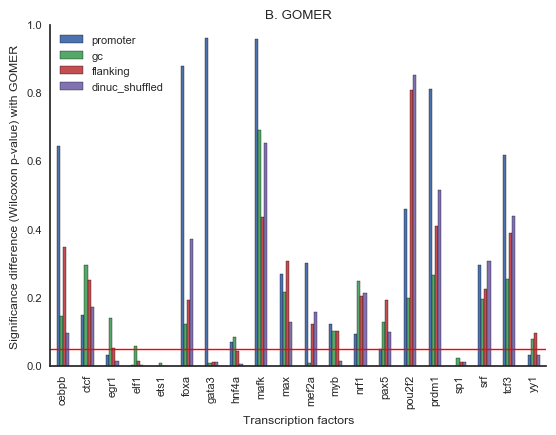

In [21]:
stat = "auc"
key = "energy"
plot_background(key,stat)

stat = "auc"
key = "gomer"
plot_background(key,stat)

For the MNCP plots, Figure B.6 and B.7

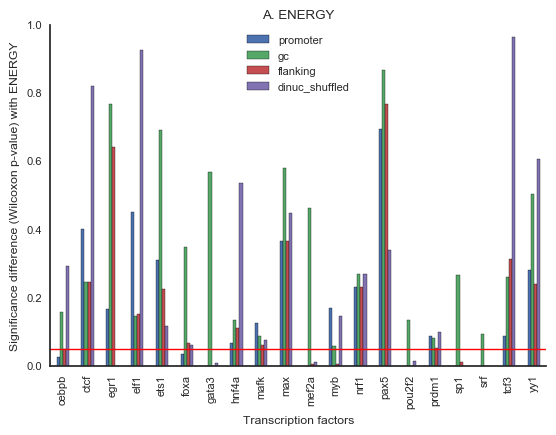

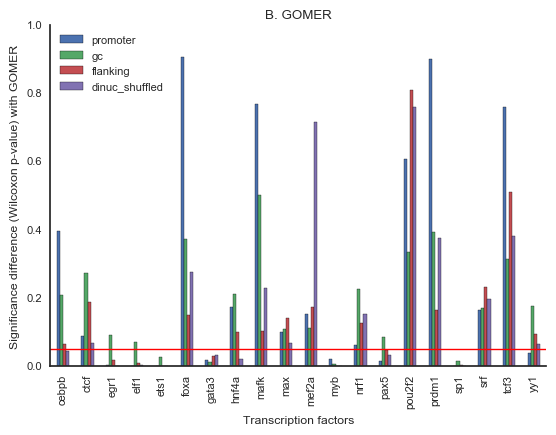

In [22]:
stat = "mncp"
key = "energy"
plot_background(key,stat)

stat = "mncp"
key = "gomer"
plot_background(key,stat)

In [24]:
test = pd.DataFrame(al_list)
test.set_index(0, inplace=True)
new_header = test.iloc[0] #grab the first row for the header
test = test[1:] #take the data less the header row
test = test.rename(columns = new_header) 
#del test["genomic"]

In [26]:
test.plot.bar(stacked=True)
plt.ylabel("Significance difference (Wilcoxon)")
plt.xlabel("Transcription factors")
sns.despine()
plt.savefig("%s/effect_of_background_gomer_wilcoxon_genomic_auc.pdf" % (figure_path), bbox_inches='tight')

In [329]:
# sns.set(style="white", context="paper")
# test.plot.bar(stacked=False)
# plt.axhline(0.05, linewidth=1, color='r')
# sns.despine()

In [15]:
#get_stat_wilcoxon_effect_size(combined_tfs_corr.T["genomic"],combined_tfs_corr.T["flanking"])

### Figure 3.5 Effect of background on motif ranking

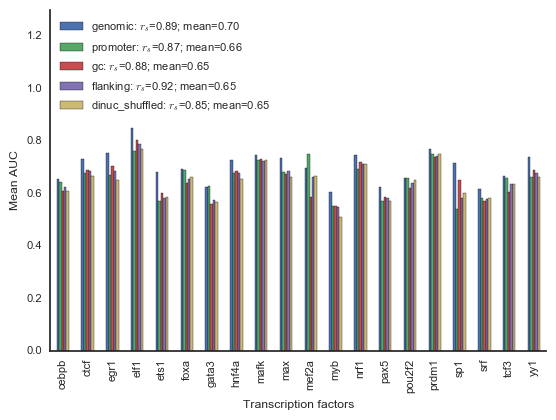

In [27]:
sns.set(style="white", context="paper")
key = "gomer"
combined_tfs_corr = pd.DataFrame()
combined_tfs_mean = pd.DataFrame()
for tf in tf_list:
    #print tf
    combined_gomer_auc = pd.DataFrame()
    for neg_type in "genomic promoter gc flanking dinuc_shuffled".split():
        results_path = '../background/%s/Results/%s' % (neg_type,tf.lower())
        test = pd.read_table('%s/%s.%s' % (results_path,tf,key))
        combined_gomer_auc[neg_type] = test["AUC"]
    #print combined_gomer_auc.corr().mean()
    combined_tfs_corr[tf] = combined_gomer_auc.corr(method="spearman").mean()
    combined_tfs_mean[tf] = combined_gomer_auc.mean()


fig, ax1 = plt.subplots()
axes = combined_tfs_mean.T.plot.bar(ax=ax1)
ave_additive = combined_tfs_corr.T.mean()
ave_additive2 = combined_tfs_mean.T.mean()
leg = list(combined_tfs_mean.T.columns)


new_leg = []
for i in leg:
    new_leg.append("%s: $r_s$=%.2f; mean=%.2f" % (i,ave_additive[i], ave_additive2[i]))
plt.ylim(ymax=1.3)
plt.ylabel("Mean AUC")
plt.xlabel("Transcription factors")
axes.legend(new_leg,loc='upper left')
sns.despine()
fig.savefig("%s/effect_of_background_gomer_mean_auc.png" % (figure_path), bbox_inches='tight')

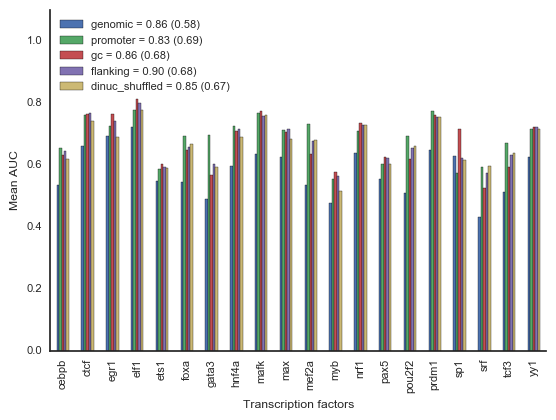

In [28]:
sns.set(style="white", context="paper")
key = "energy"
combined_tfs_corr = pd.DataFrame()
combined_tfs_mean = pd.DataFrame()
for tf in tf_list:
    #print tf
    combined_gomer_auc = pd.DataFrame()
    for neg_type in "genomic promoter gc flanking dinuc_shuffled".split():
        results_path = '../background/%s/Results/%s' % (neg_type,tf.lower())
        test = pd.read_table('%s/%s.%s' % (results_path,tf,key))
        combined_gomer_auc[neg_type] = test["AUC"]
    #print combined_gomer_auc.corr().mean()
    combined_tfs_corr[tf] = combined_gomer_auc.corr(method="spearman").mean()
    combined_tfs_mean[tf] = combined_gomer_auc.mean()


fig, ax1 = plt.subplots()
axes = combined_tfs_mean.T.plot.bar(ax=ax1)
ave_additive = combined_tfs_corr.T.mean()
ave_additive2 = combined_tfs_mean.T.mean()
leg = list(combined_tfs_mean.T.columns)
new_leg = []
for i in leg:
    new_leg.append("%s = %.2f (%.2f)" % (i,ave_additive[i], ave_additive2[i]))
plt.ylim(ymax=1.1)
plt.ylabel("Mean AUC")
plt.xlabel("Transcription factors")
axes.legend(new_leg,loc='upper left')
sns.despine()
fig.savefig("%s/effect_of_background_energy_mean_auc.png" % (figure_path), bbox_inches='tight')

In [241]:
score_key = ['energy', 'gomer']
neg_type = "genomic"
stat = 'AUC'
for tf in {"ctcf"}:
    results_path = '../background/%s/Results/%s' % (neg_type,tf.lower())
    #results_path = '%s/ChIP_seq/Results/%s' % (BASE_DIR, tf)
    raw_data = []
    raw_data.append(["Motif"])
    flag = 0
    for key in score_key:
        i = 1
        raw_data[0].append(key)
        with open('%s/%s.%s' % (results_path,tf,key)) as score_out:
            for line in score_out:
                if line.split()[1]=="AUC":
                    continue
                else:
                    if flag ==0:
                        raw_data.append([line.split()[0]])
                        raw_data[i].append(line.split()[4])
                        i+=1
                    else:
                        raw_data[i].append(line.split()[4])
                        i+=1
            flag = 1
        with open("%s/%s_%s.rawscores" %(results_path,tf, stat), 'w') as raw_out:
            for row in raw_data:
                raw_out.writelines('\t'.join(map(str, row)) + '\n')

## Evaluate the Scoring funtions

Assuming the motifs have been generated, they can be used to score the above sequences using the following scoring functions:

    1. gomeroccupnacyscore
    2. energyscore
    3. maxoccupancyscore
    4. occupancyscore
    5. occupancyscore
    6. sumlogoddsscore
    7. maxlogoddsscore
In my case, I querried a local motf database for motifs for a given TF.


### Effect of scoring functions on motif ranking

Having established how the choice of backround sequence affect motif ranking, we turn our attention to the effect of the scoring functions used. For this, we use flanking sequence as our background sequence.

First, we set the necessary folders using Ctcf as an example. 

In [160]:
BASE_DIR = os.path.dirname(os.path.dirname(os.path.abspath('Assess_motifsdb.py')))

def mkdir_p(path):
    try:
        os.makedirs(path)
    except OSError as exc:
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise
tf = 'ctcf'
results_path = '%s/ChIP_seq/Results/%s' % (BASE_DIR, tf)
mkdir_p(results_path)

For each TF, we get all the ChIpseq data available for analsysis. 

In [109]:
import glob
chip_seq_list = glob.glob('%s/ChIP_seq/Data/Derived/%s/*' % (BASE_DIR, tf))

We use gomeroccupancy score for this demo, but a quick run for all the motifs can be run by looping though all the scoring functions as follows:

In [10]:
#for key in assess.score_extensions:
    #assess.run_all(tf, key, '%s/Data/Motifs/%s.meme' %(BASE_DIR, tf), chip_seq_list, results_path)

Uncomment the above cell for a quick run of all the scoring functions. Internally, the program chooses 10 random sequences, in a situation where more than 10 are available. We observed no better discrimination from more data, just takes lots of time. 

In [238]:
# key = 'energyscore'
# assess.run_all(tf, key, '%s/Motifs/%s.meme' %(BASE_DIR, tf), chip_seq_list, results_path)

### Combining the above steps to loop through multiple TFs and scoring functions

In [13]:
tf_list = "cebpb ctcf egr1 elf1 esrra ets1 gata3 hnf4a mafk max mef2a myb nrf1 pax5 pou2f2 prdm1 sp1 srf tcf3 yy1".split()
for tf in tf_list:
    results_path = '%s/ChIP_seq/Results/%s' % (BASE_DIR, tf)
    
    #make results path
    mkdir_p(results_path)
    
    #Exract the available ChIP-seq list
    chip_seq_list = glob.glob('%s/ChIP_seq/Data/Derived/%s/*' % (BASE_DIR, tf))
    
    test_meme_input = '%s/ChIP_seq/Data/Motifs/%s.meme' %(BASE_DIR, tf)
    
    for key in assess.score_extensions:
        assess.run_all(tf, key, test_meme_input, chip_seq_list, results_path)

## Further figures

The above steps will only get up as far as obtaining the raw initial results. The steps that follow, outlines how the data was further processed and plotted. 

In [33]:
tf_list = "cebpb ctcf egr1 elf1 esrra ets1 gata3 hnf4a mafk max mef2a myb nrf1 pax5 pou2f2 prdm1 sp1 srf tcf3 yy1".split()

score_key = ['energy', 'gomer','sumlog', 'sumoc','maxoc', 'ama', 'maxlog']
stat = 'spearman'
for tf in tf_list:
    results_path = '%s/ChIP_seq/Results/%s' % (BASE_DIR, tf)
    raw_data = []
    raw_data.append(["Motif"])
    flag = 0
    for key in score_key:
        i = 1
        raw_data[0].append(key)
        with open('%s/%s.%s' % (results_path,tf,key)) as score_out:
            for line in score_out:
                if line.split()[1]=="AUC":
                    continue
                else:
                    if flag ==0:
                        raw_data.append([line.split()[0]])
                        raw_data[i].append(line.split()[4])
                        i+=1
                    else:
                        raw_data[i].append(line.split()[4])
                        i+=1
            flag = 1
        with open("%s/%s_%s.rawscores" %(results_path,tf, stat), 'w') as raw_out:
            for row in raw_data:
                raw_out.writelines('\t'.join(map(str, row)) + '\n')

In [ ]:
#tf_list = "cebpb ctcf egr1 elf1 esrra ets1 gata3 hnf4a mafk max mef2a myb nrf1 pax5 pou2f2 prdm1 sp1 srf tcf3 yy1".split()

score_key = ['energy', 'gomer']
stat = 'spearman'
for tf in tf_list:
    results_path = '%s/ChIP_seq/Results/%s' % (BASE_DIR, tf)
    raw_data = []
    raw_data.append(["Motif"])
    flag = 0
    for key in score_key:
        i = 1
        raw_data[0].append(key)
        with open('%s/%s.%s' % (results_path,tf,key)) as score_out:
            for line in score_out:
                if line.split()[1]=="AUC":
                    continue
                else:
                    if flag ==0:
                        raw_data.append([line.split()[0]])
                        raw_data[i].append(line.split()[4])
                        i+=1
                    else:
                        raw_data[i].append(line.split()[4])
                        i+=1
            flag = 1
        with open("%s/%s_%s.rawscores" %(results_path,tf, stat), 'w') as raw_out:
            for row in raw_data:
                raw_out.writelines('\t'.join(map(str, row)) + '\n')

#### MOTIF INFORMATION CONTENT AND LENGTH

Summarize the motifs' information content, length as well as their scores. This is used to determine the level of correlation between the motif chracter and the scores asigned. This helps understand how IC and motif length affect the score asigned by various scores.

In [29]:
#!/usr/bin/python
from __future__ import print_function
import sys
from math import log
import os

def mot_summary(motif_file, raw_scores, out_file):
    '''
    Summary of motif and score
    '''
    found = 0
    row = 0
    n_rows = 0
    entropy = 0
    total_entropy = 0
    motifs = 0
    name = ""
    raw_dict = {}
    with open(out_file, "w") as write_out:

        with open(raw_scores) as raw_in:
            for line in raw_in:
                raw_dict[line.split()[0]] = line.split()[1:]
        out = "Motif_name\tMotif_IC\tAverage_IC\tMotif_length\t%s\t%s\t%s\t%s\n" % \
              (raw_dict["Motif"][0], raw_dict["Motif"][1], raw_dict["Motif"][2], raw_dict["Motif"][3])

        write_out.write(out)
        with open(motif_file, "r") as motif_file:
            for line in motif_file:
                words = line.split()
                if found == 0:
                    if line.startswith("MOTIF"):
                        # allow for motifs without an alternative name
                        if len(words) < 3:
                            words.append("")
                        name = (words[1])
                        found = 1
                        motifs += motifs
                        entropy = 0
                        continue
                if found == 1:
                    if line.startswith("letter-probability"):
                        n_rows = int((line.split("w="))[1].split()[0])
                        found = 2
                    continue
                if found == 2:
                    if line == "\n":
                        continue
                    else:
                        check = 0
                    for val in words:
                        if float(val) > 0:
                            check += float(val) * log(float(val))/log(2.0)
                            entropy += float(val) * log(float(val))/log(2.0)
                    row += 1
                    if row >= n_rows:
                        v = 2*n_rows+entropy
                        out = '%s\t%f\t%f\t%i\t%f\t%f\t%f\t%f\n'\
                              % (name, v, (v/n_rows), n_rows, float(raw_dict[name][0]), float(raw_dict[name][1]),
                                 float(raw_dict[name][2]), float(raw_dict[name][3]))
                        write_out.write(out)
                        #n+= 1
                        #print(n)
                        found = 0
                        row = 0
                        total_entropy += (v/n_rows)

In [36]:
statistics = ['auc','mncp']
#tf_list = "cebpb ctcf egr1 elf1 esrra ets1 gata3 hnf4a mafk max mef2a myb nrf1 pax5 pou2f2 prdm1 sp1 srf tcf3 yy1".split()
for stat in statistics:
    for tf in tf_list:
        meme_file = '%s/Motifs/%s.meme' %(BASE_DIR, tf)
        results_path = '%s/ChIP_seq/Results/%s' % (BASE_DIR, tf)
        test = mot_summary(meme_file,"%s/%s_%s.rawscores" % (results_path, tf, stat), "%s/%s_%s_score_ic.txt" % (results_path, tf, stat))

In [19]:
tf = 'ctcf'
results_path = '%s/Results/%s' % (BASE_DIR, tf)

In [43]:
sns.set(style="white", context="poster")

### Effect of cell lines on motif ranking

/home/workshop/miniconda2/envs/dream_challenge/lib/python2.7/site-packages/ipykernel/__main__.py:16: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


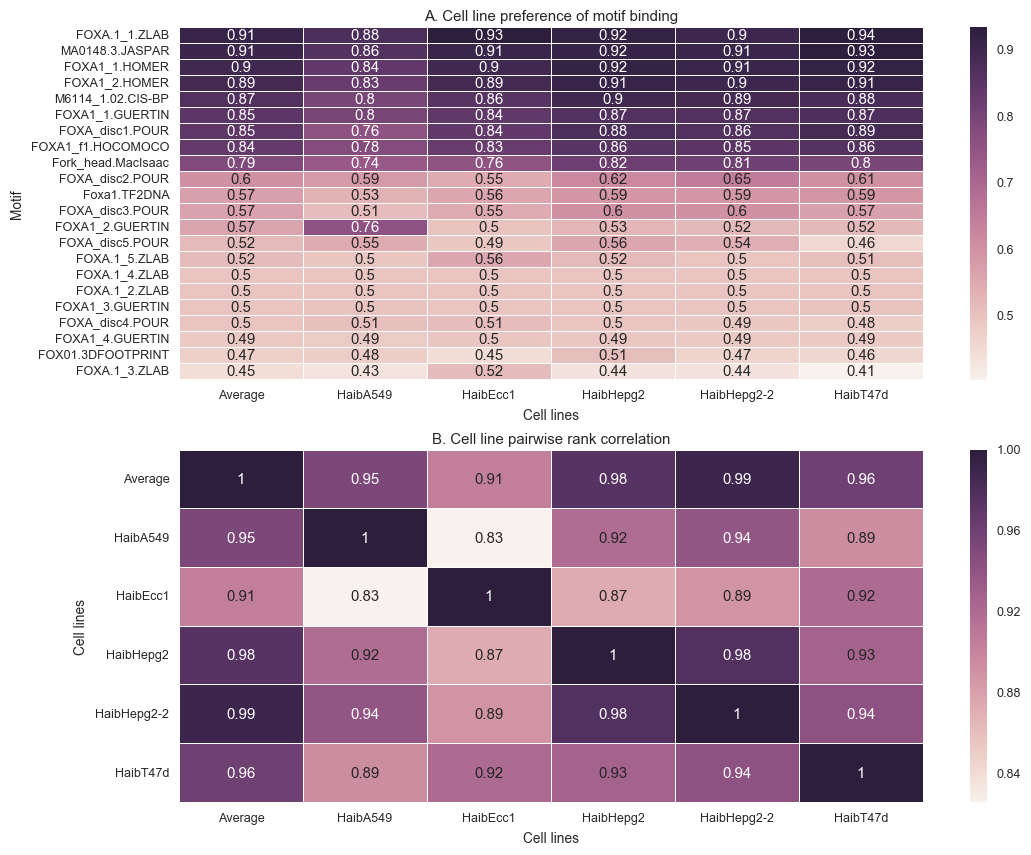

In [162]:
def plot_raw_assess(raw_data, figure_output, stat):
    """
    This function allows the raw data to be plotted  in the form of a heatmap.
    
    This way, information about how each motif scores in different cell lines is
    obtained
    """
    #Increase the font
    fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 10), sharex=False, sharey=False)
    sns.set(font_scale=0.9)
    #sns.set_style("white")
    raw_max = pd.read_table(raw_data)
    raw_max = raw_max.drop_duplicates()
    
    raw_edit = raw_max.pivot('Motif', 'Cell_lab', stat)
    raw_edit.sort(columns="Average", axis=0, ascending=False, inplace=True)
    #fig, ax = plt.subplots()
    ax1.set_title('A. Cell line preference of motif binding')
    ax2.set_title('B. Cell line pairwise rank correlation')
    ax1.set_xlabel("Cell lines")
    # the size of A4 paper
    #fig.set_size_inches(11, 8)
    raw_edit.columns.name = "Cell lines"
    sns.heatmap(raw_edit, ax = ax1, annot=True ,linewidths=0.005)
    sns.heatmap(raw_edit.corr(method='spearman'), ax = ax2, annot=True,linewidths=0.005)
    f = plt.gcf()
    f.savefig(figure_output, bbox_inches='tight')
    return raw_edit

raw_edit = plot_raw_assess("../ChIP_seq/Results/foxa/foxa_raw.gomer", 
                           '%s/Figure4_cell_line_specific_gomer.pdf' % figure_path, 'AUC')

### Table 3.3: Inluence of cell lines on motif scoring and ranking

In [163]:
full_list = []
for tf in tf_list:
    #print tf
#     raw_edit = plot_raw_assess("../ChIP_seq/Results/%s/%s_raw.gomer" % (tf,tf), 
#                                '../Figures/Figure4_cell_line_specific_gomer.pdf', 'AUC')
    raw_edit = plot_raw_assess("../background/flanking/Results/%s/%s_raw.energy" % (tf,tf), '../Figures/Figure4_cell_line_specific_gomer.pdf', 'AUC')
    for col in raw_edit.columns:
        for col2 in raw_edit:
            my_val = get_stat_wilcoxon_effect_size(raw_edit[col],raw_edit[col2])[0]
            if  my_val < 0.05:
                print tf,col,col2,my_val
                new_l = [tf]
                new_l = new_l[:]
                new_l.append(col)
                new_l.append(col2)
                new_l.append(my_val)
    full_list.append(new_l[:])
    
#                 print col
#                 print col2,my_val
                

### Copy below and get Pandas DataFrame 

Create latex table

In [116]:
TF Cell_line1 Cell_line2 Wilcoxon
cebpb HaibGm12878Cebpbsc150V0422111 Average 0.00268017172807
cebpb HaibGm12878Cebpbsc150V0422111 HaibHepg2Cebpbsc150V0416101 0.000370393745759
cebpb HaibGm12878Cebpbsc150V0422111 HaibK562Cebpbsc150V0422111 0.00159849373854
cebpb HaibGm12878Cebpbsc150V0422111 SydhA549CebpbIggrab 0.00323491191691
cebpb HaibGm12878Cebpbsc150V0422111 SydhH1hescCebpbIggrab 0.00243673480899
cebpb HaibGm12878Cebpbsc150V0422111 SydhHelas3CebpbIggrab 0.00221369195459
cebpb HaibGm12878Cebpbsc150V0422111 SydhHepg2CebpbForskln 0.00294564615053
cebpb HaibGm12878Cebpbsc150V0422111 SydhHepg2CebpbIggrab 0.00354983863491
cebpb HaibGm12878Cebpbsc150V0422111 SydhImr90CebpbIggrab 0.00251553549738
cebpb HaibGm12878Cebpbsc150V0422111 SydhK562CebpbIggrab 0.00628001159667
gata3 HaibT47dGata3sc268V0416102Dm002p1h SydhShsy5yGata3sc269sc269Ucd 0.0201846528804
gata3 SydhShsy5yGata3sc269sc269Ucd SydhMcf7Gata3Ucd 0.0168468410067
sp1 HaibHepg2Sp1Pcr1x Average 0.00869398609813
sp1 HaibHepg2Sp1Pcr1x HaibGm12878Sp1Pcr1x 0.00802755320632
sp1 HaibHepg2Sp1Pcr1x HaibH1hescSp1Pcr1x 0.00267719296031
sp1 HaibHepg2Sp1Pcr1x HaibK562Sp1Pcr1x 0.00683025586304
srf HaibHepg2SrfV0416101 HaibK562SrfV0416101 0.0300518776639

In [130]:
effect_of_cell = pd.read_clipboard()
effect_of_cell.set_index(0, inplace=True)

In [141]:
effect_of_cell.to_latex("%s/latex" % figure_path, index=False)

In [345]:
effect_of_cell.pivot_table(index="TF", values="Wilcoxon")

TF
cebpb    0.002783
gata3    0.018516
sp1      0.006557
srf      0.030052
Name: Wilcoxon, dtype: float64

In [57]:
np.std(raw_edit.values)

0.10434773616254979

In [82]:
# for col in raw_edit.columns:
#     for col2 in raw_edit:
#         print get_stat_wilcoxon_effect_size(raw_edit[col],raw_edit[col2])[0]

### Figure 5...Effect of statistics on motif ranking 

In [37]:
def set_style():
    # This sets reasonable defaults for font size for
    # a figure that will go in a paper
    sns.set_context("poster")
    
    # Set the font to be serif, rather than sans
    sns.set(font='times')
    #sns.set_style(despine=True)
    # Make the background white, and specify the
    # specific font family
    sns.set_style("white", {
        "font.family": "times",
        "font.serif": ["Times", "Palatino", "serif"]
    })
    #sns.set(despine=True)

In [38]:
set_style()
combined_tfs_corr = pd.DataFrame()
combined_tfs_corr[tf] = combined_gomer_auc.corr(method="spearman").mean()

Sp1 is removed because it seems like an outlier

In [96]:
tf_list.pop(tf_list.index("sp1"))

'sp1'

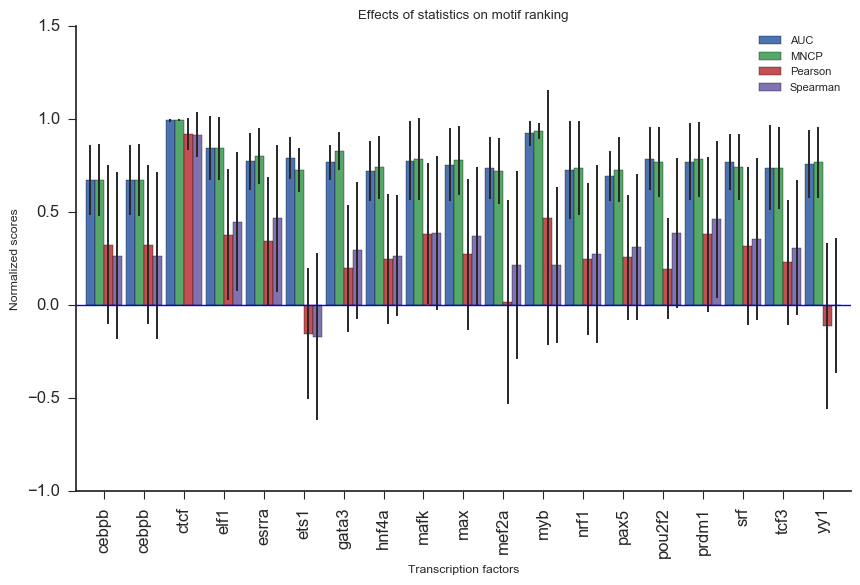

In [133]:

score = 'gomer'
#tf_list = "ctcf egr1 elf1 esrra ets1 gata3 hnf4a mafk max mef2a myb nrf1 pax5 pou2f2 prdm1 srf tcf3 yy1".split()

tf = 'cebpb'
chip = pd.read_table('../ChIP_seq/Results/%s/%s.%s' % (tf, tf, score), index_col='Motif')
chip = chip/chip.max()
chip_std = chip.std().to_frame(name=tf).T
chip_mean = np.mean(chip).to_frame(name=tf)
chip_mean_test = chip_mean.T
rank_sum = ranksums(chip['AUC'],chip['Spearman'])[1] # compute wilcoxon rank-sum test
combined_tfs_corr = pd.DataFrame()
for tf in tf_list:
    chip = pd.read_table('../ChIP_seq/Results/%s/%s.%s' % (tf, tf, score), index_col='Motif')
    chip = chip/chip.max()
    #rank_sum += ranksums(chip['AUC'],chip['Spearman'])[1]
    #print(get_stat_wilcoxon_effect_size(chip['AUC'],chip['Pearson'])[0])
    chip_s = chip.std().to_frame(name=tf)
    chip_std = chip_std.append(chip_s.T)
    chip_mean = np.mean(chip).to_frame(name=tf)
    combined_tfs_corr[tf] = chip.corr(method="spearman").median()
    chip_mean_test = chip_mean_test.append(chip_mean.T)
#chip_mean_test = chip_mean_test.drop("sp1")
ax = chip_mean_test.plot(kind='bar',yerr=chip_std,
                  title="Effects of statistics on motif ranking", fontsize=12, figsize=(10,6),width=0.9)
#ax.grid(False)
sns.despine()
ax.set_xlabel("Transcription factors")
ax.set_ylabel("Normalized scores")
plt.axhline(0.00, linewidth=1, color='b')
ax.set_axis_bgcolor('W')
for lin in ax.lines:
    lin.set_markersize(0.05)
#     #lin.set_markeredgewidth(0.5)
fig = ax.get_figure()
fig.savefig('%s/Figure5_score_and_statistic_new-bigger.png' % figure_path, bbox_inches="tight")
#fig.savefig('../Figures/Figure5_score_and_statistic_new.pdf')


In [53]:
chip.std()

AUC         0.181299
MNCP        0.191293
Pearson     0.446970
Spearman    0.362776
dtype: float64

In [67]:
al_list = ["Tf genomic promoter gc flanking dinuc_shuffled".split()]
key = "gomer"
combined_tfs_corr = pd.DataFrame()
combined_tfs_mean = pd.DataFrame()
for tf in tf_list:
    #print tf
    combined_gomer_auc = pd.DataFrame()
    for neg_type in "genomic promoter gc flanking dinuc_shuffled".split():
        results_path = '../background/%s/Results/%s' % (neg_type,tf.lower())
        test = pd.read_table('%s/%s.%s' % (results_path,tf,key))
        combined_gomer_auc[neg_type] = test["AUC"]
    new_l = [tf]
    for neg_type in "genomic promoter gc flanking dinuc_shuffled".split():
        #print neg_type
        #for neg in "genomic promoter gc flanking dinuc_shuffled".split():
        new_l.append(get_stat_wilcoxon_effect_size(combined_gomer_auc[neg_type],combined_gomer_auc["genomic"])[0])
    al_list.append(new_l[:])

In [648]:
chip.corr(method="spearman").median()

AUC         0.228245
MNCP        0.309975
Pearson     0.297027
Spearman    0.316756
dtype: float64

We observe the choice of negative sequences to have little effect on the ranks assigned to the motifs. In the figure above, we computed and plotted the rank correlation of scores normalized by maximum score for each TF. However some TFs seem to be affected most by this. This generally seems to affect motifs with indirect (Myb) of flanking site binding (Tcf3)

### Figure 3.9: Effect of scoring functons on motif ranking -- auc

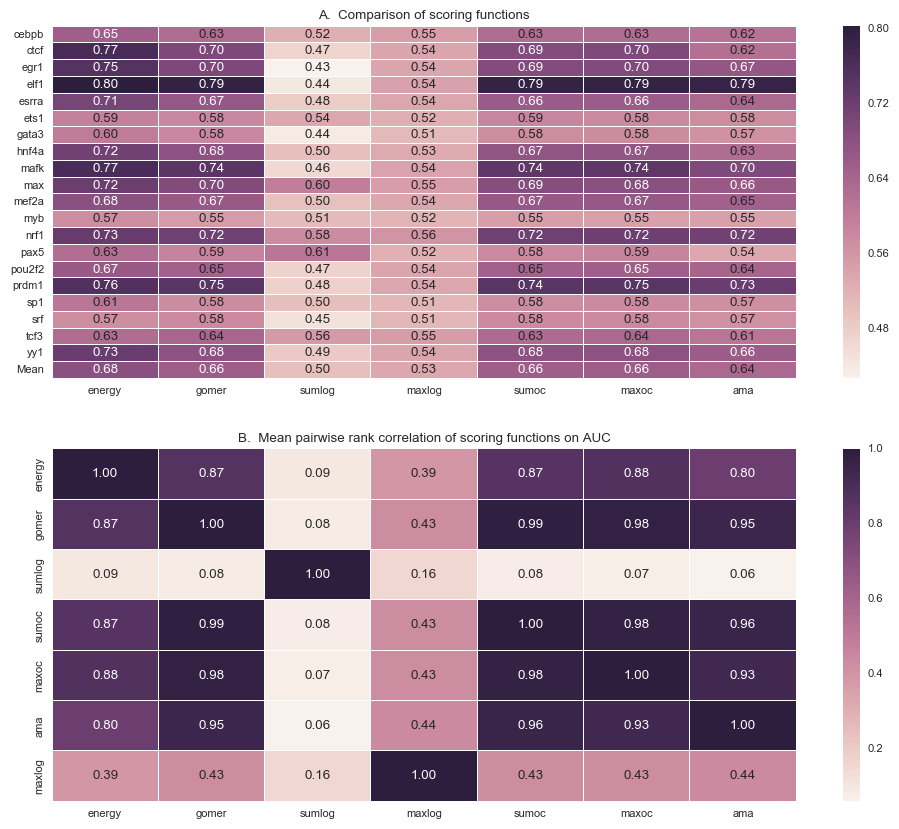

In [61]:
stat='auc'
tf_list="cebpb ctcf egr1 elf1 esrra ets1 gata3 hnf4a mafk max mef2a myb nrf1 pax5 pou2f2 prdm1 sp1 srf tcf3 yy1".split()
#tf_list = "esrra gata3 hnf4a mafk max myb pou2f2 tcf3 ".split()
#fig, ax = plt.subplots()
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 10), sharex=False, sharey=False)
#sns.set(font_scale=1.2)

#fig.set_size_inches(10, 8)

scores = "energy	gomer	sumlog	maxlog	sumoc	maxoc	ama".split()

score_sum = pd.DataFrame(columns=scores)
for tf in tf_list:
    mot_score =pd.read_table("../ChIP_seq/Results/%s/%s_%s.rawscores" % (tf,tf, stat), index_col="Motif")
    test = mot_score.mean().T
    con = test.to_frame(name=tf).T
    score_sum = score_sum.append(con)
score_sum = score_sum.append(score_sum.mean().to_frame(name="Mean").T)
sns.heatmap(score_sum[scores], annot=True, ax=ax1, fmt='.2f',linewidths=0.005, linecolor='white')

ax1.xaxis.set_label_position('bottom') 
#ax1.xaxis.tick_top()
ax1.autoscale(tight=True) 
ax1.set_title("A.  Comparison of scoring functions")

tf = 'ctcf'
stat = 'auc'
mot_score =pd.read_table("../ChIP_seq/Results/%s/%s_%s.rawscores" % (tf,tf, stat), index_col="Motif")
a = mot_score.corr(method='spearman')

#sns.clustermap(mot_score.corr(method='spearman'))

tf_list ="cebpb egr1 elf1 esrra ets1 gata3 hnf4a mafk max mef2a myb nrf1 pax5 pou2f2 prdm1 sp1 srf tcf3 yy1".split()
#tf_list = "gata3 hnf4a mafk max myb pou2f2 tcf3".split()
for tf in tf_list:
    mot_score =pd.read_table("../ChIP_seq/Results/%s/%s_%s.rawscores" % (tf,tf, stat), index_col="Motif")
    b = mot_score.corr(method='spearman')
    a = a.add(b)
sns.heatmap(a[scores]/20, annot=True, ax=ax2, fmt='.2f',linewidths=0.005)
ax2.set_title("B.  Mean pairwise rank correlation of scoring functions on AUC")
f=plt.gcf()
f.savefig('%s/Figure6_effect_of_scoring_auc_new.png' % figure_path, bbox_inches='tight')

In [64]:
al_list = ["Tf energy	gomer	sumlog	maxlog	sumoc	maxoc    ama".split()]
sns.set(style="white", context="paper")
neg_type = "flanking"
combined_tfs_corr = pd.DataFrame()
combined_tfs_mean = pd.DataFrame()
for tf in tf_list:
    #print tf
    combined_gomer_auc = pd.DataFrame()
    for key in "energy	gomer	sumlog	sumoc	maxoc    ama	maxlog".split():
        #/media/Elements/PhD/Project/Motif_Assessment/PAPER_Assessment_Data/Kibet-F1000Research/ChIP_seq/Results/esrra
        results_path = '../ChIP_seq/Results/%s' % (tf.lower())
        test = pd.read_table('%s/%s.%s' % (results_path,tf,key))
        combined_gomer_auc[key] = test["MNCP"]
    new_l = [tf]
    for key in "energy	gomer	sumlog	maxlog	sumoc	maxoc    ama".split():
        #print neg_type
        #for neg in "genomic promoter gc flanking dinuc_shuffled".split():
        new_l.append(get_stat_wilcoxon_effect_size(combined_gomer_auc[key],combined_gomer_auc["gomer"])[0])
    al_list.append(new_l[:])

### Check how motif ranks relate in different factions

In [65]:
#pd.DataFrame(al_list)
test = pd.DataFrame(al_list)
test.set_index(0, inplace=True)
new_header = test.iloc[0] #grab the first row for the header
test = test[1:] #take the data less the header row
test = test.rename(columns = new_header) 
del test["gomer"]

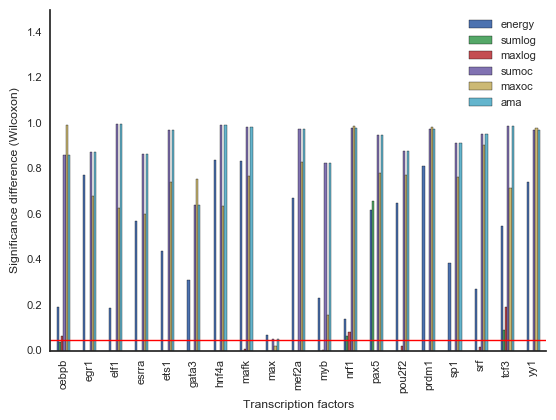

In [66]:
test.plot.bar(stacked=False)
plt.axhline(0.05, linewidth=1, color='r')
plt.ylabel("Significance difference (Wilcoxon)")
plt.xlabel("Transcription factors")
plt.ylim(ymax=1.5)
sns.despine()
sns.despine()
fig.savefig("%s/effect_of_score_fun_wilcoxon_mncp.pdf" % (figure_path), bbox_inches='tight')

In [74]:
test.mean()

energy    0.577778
sumlog    0.045852
sumoc     0.875201
maxoc     0.785904
ama       0.875201
maxlog    0.014410
dtype: float64

### Plot for scoring functions

In [96]:
#al_list = ["Tf energy	gomer	sumlog	sumoc	maxoc    ama	maxlog".split()]
sns.set(style="white", context="paper")

def plot_funtion(key_list, stat, label):
    neg_type = "flanking"
    
    combined_tfs_corr = pd.DataFrame()
    combined_tfs_mean = pd.DataFrame()
    for tf in tf_list:
        #print tf
        combined_gomer_auc = pd.DataFrame()
        for key in key_list:
            results_path = '../background/%s/Results/%s' % (neg_type,tf.lower())
            test = pd.read_table('%s/%s.%s' % (results_path,tf,key))
            combined_gomer_auc[key] = test[stat.upper()]
        #print combined_gomer_auc.corr().mean()
        combined_tfs_corr[tf] = combined_gomer_auc.corr(method="spearman").mean()
        combined_tfs_mean[tf] = combined_gomer_auc.mean()


    fig, ax1 = plt.subplots()
    axes = combined_tfs_mean.T.plot.bar(ax=ax1)
    ave_additive = combined_tfs_corr.T.mean()
    ave_additive2 = combined_tfs_mean.T.mean()
    leg = list(combined_tfs_mean.T.columns)


    new_leg = []
    for i in leg:
        new_leg.append("%s: $r_s$=%.2f; mean=%.2f" % (i,ave_additive[i], ave_additive2[i]))
    if stat.upper() == "MNCP":
        if label == "all":
            plt.ylim(ymax=2.5)
        else:
            plt.ylim(ymax=2.0)
    else:
        plt.ylim(ymax=1.0)
        
    plt.ylabel("Mean %s for %s functions" % (stat.upper(),label) )
    plt.xlabel("Transcription factors")
    axes.legend(new_leg,loc='upper left')
    sns.despine()
    fig.savefig("%s/effect_of_score_fun_mean_%s_%s.pdf" % (figure_path, stat.lower(), label.replace(" ", "")), bbox_inches='tight')

### Figure B.9: Effect of occupancy scoring on motif ranking

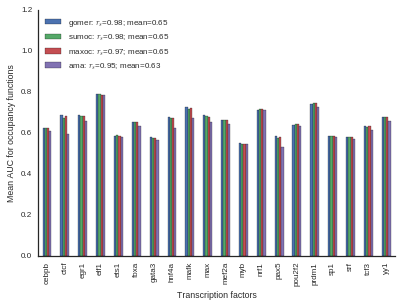

In [93]:
key_list = "gomer	sumoc	maxoc    ama".split()
stat = "auc"
label = "occupancy"
plot_funtion(key_list, stat, label)

### Figure 3.10: Effect of scoring function among the best three non-redundant functions

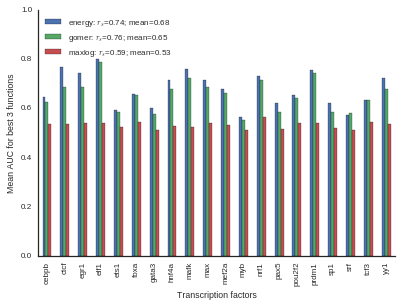

In [98]:
key_list = "energy	gomer	maxlog".split()
stat = "auc"
label = "best 3"
plot_funtion(key_list, stat, label)

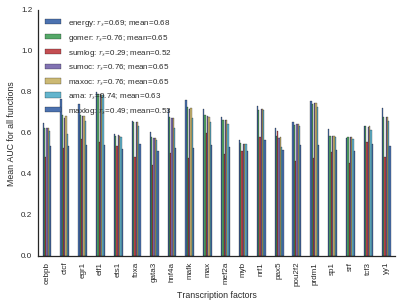

In [90]:
key_list = "energy	gomer	sumlog	sumoc	maxoc    ama	maxlog".split()
stat = "auc"
label = "all"
plot_funtion(key_list, stat, label)

In [401]:
ave_additive

energy    0.694316
gomer     0.762295
sumlog    0.288043
sumoc     0.764349
maxoc     0.759293
ama       0.737160
maxlog    0.490836
dtype: float64

#### Table S1: Determine the significance of the difference between the AUC values of the various scoring functions using Wilcoxon rank-sum statistic 

**NB**: This should only be run after the above section to generate the score_sum dataframe

In [29]:
scores = "energy	gomer	sumlog	sumoc	maxoc    ama	maxlog".split()
ans = []
#ans.append(scores)
i = 0
for score1 in scores:
    ans.append([score1])
    for score2 in scores:
        ans[i].append(ranksums(score_sum[score1],score_sum[score2])[1])
    i+=1
scores = "Scoring_function energy	gomer	sumlog	sumoc	maxoc    ama	maxlog".split()
pvalues = pd.DataFrame(ans, columns=scores)     

#Save to csv file
pvalues.to_csv('../Supplementary_Tables/Table_S1.csv')

### Figure B.11 Effect_of_scoring fucntion with MNCP statistic

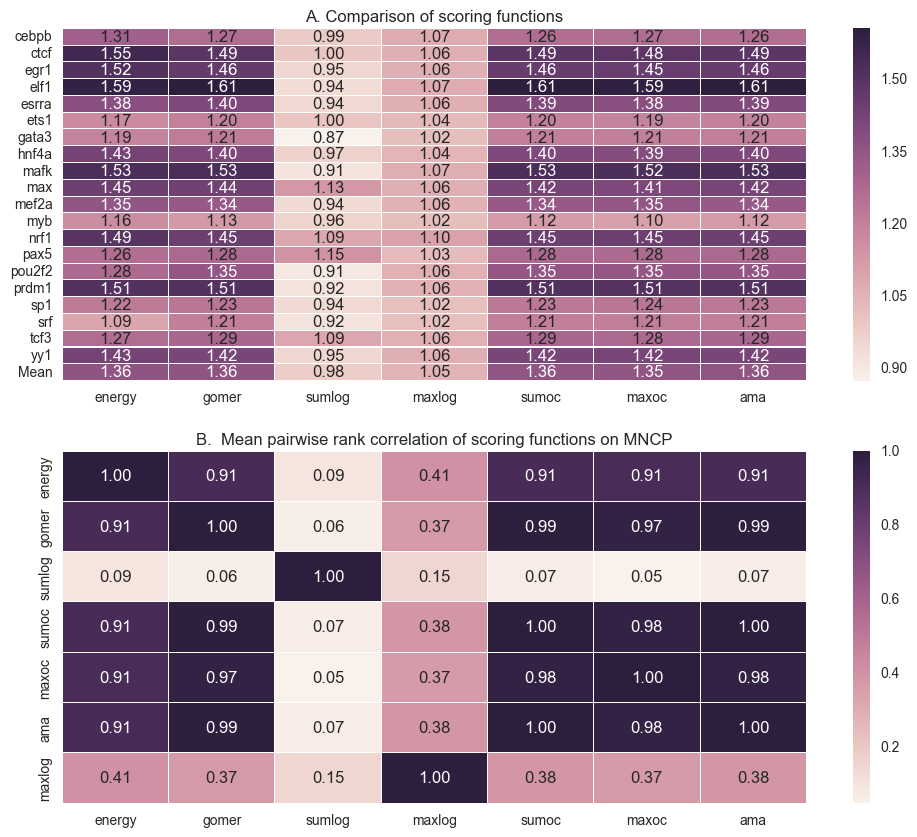

In [77]:
stat='mncp'
tf_list = "cebpb ctcf egr1 elf1 esrra ets1 gata3 hnf4a mafk max mef2a myb nrf1 pax5 pou2f2 prdm1 sp1 srf tcf3 yy1".split()

fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 10), sharex=False, sharey=False)
#fig, ax = plt.subplots()

sns.set(font_scale=1)

#fig.set_size_inches(10, 8)

scores = "energy	gomer	sumlog	maxlog	sumoc	maxoc  ama".split()

score_sum = pd.DataFrame(columns=scores)
for tf in tf_list:
    mot_score =pd.read_table("../ChIP_seq/Results/%s/%s_%s.rawscores" % (tf,tf, stat), index_col="Motif")
    test = mot_score.mean().T
    con = test.to_frame(name=tf).T
    score_sum = score_sum.append(con)
score_sum = score_sum.append(score_sum.mean().to_frame(name="Mean").T)
sns.heatmap(score_sum[scores], annot=True, ax=ax1, fmt='.2f',linewidths=0.005)
ax1.set_title("A. Comparison of scoring functions")

tf = 'ctcf'
stat = 'mncp'
mot_score =pd.read_table("../ChIP_seq/Results/%s/%s_%s.rawscores" % (tf,tf, stat), index_col="Motif")
a = mot_score.corr(method='spearman')

#sns.clustermap(mot_score.corr(method='spearman'))

tf_list = "cebpb egr1 elf1 esrra ets1 gata3 hnf4a mafk max mef2a myb nrf1 pax5 pou2f2 prdm1 sp1 srf tcf3 yy1".split()
for tf in tf_list:
    mot_score =pd.read_table("../ChIP_seq/Results/%s/%s_%s.rawscores" % (tf,tf, stat), index_col="Motif")
    b = mot_score.corr(method='spearman')
    a = a.add(b)
sns.heatmap(a[scores]/20, annot=True, ax=ax2, fmt='.2f',linewidths=0.005)
ax2.set_title("B.  Mean pairwise rank correlation of scoring functions on MNCP")
#f=plt.gcf()
#f.savefig('../Figures/Figure6_effect_of_scoring_auc.pdf', bbox_inches='tight')
f=plt.gcf()
f.savefig('%s/Figure7_effect_of_scoring_mncp_new.png' % figure_path, bbox_inches='tight')

#### Table S2: Determine the significance of the difference between the MNCP values of the various scoring functions using Wilcoxon rank-sum statistic 

**NB**: This should only be run after the above section to generate the score_sum dataframe

In [31]:
from scipy.stats import ranksums
scores = "energy	gomer	sumlog	sumoc	maxoc    ama	maxlog".split()
ans = []
#ans.append(scores)
i = 0
for score1 in scores:
    ans.append([score1])
    for score2 in scores:
        ans[i].append(ranksums(score_sum[score1],score_sum[score2])[1])
    i+=1
scores = "Scoring_function energy	gomer	sumlog	sumoc	maxoc    ama	maxlog".split()
pvalues = pd.DataFrame(ans, columns=scores)     

#Save to csv file
pvalues.to_csv('../Supplementary_Tables/Table_S2.csv')

### Figure B.12 How motif IC and length influence motif scoring and ranking

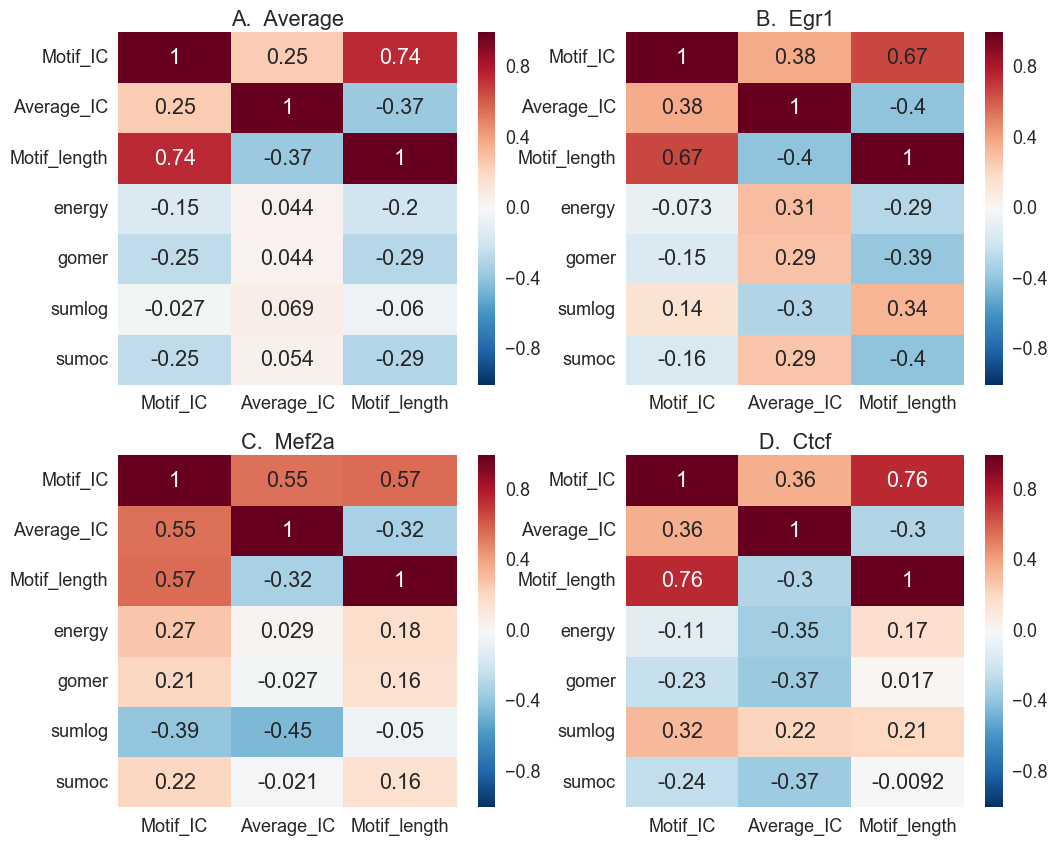

In [94]:
tf ='egr1' #initialize
stat = 'auc'
tf_list = "cebpb ctcf elf1 esrra ets1 gata3 hnf4a mafk max mef2a myb nrf1 pax5 pou2f2 prdm1 sp1 srf tcf3 yy1".split()

tf_path = "../ChIP_seq/Results/%s" % (tf)
df = pd.read_table("%s/%s_%s_score_ic.txt" % (tf_path, tf, stat), index_col="Motif_name")
score_ic = df.corr()

for tf in tf_list:
    tf_path = "../ChIP_seq/Results/%s" % (tf)
    #df = tf+"_df"
    df1 = pd.read_table("%s/%s_%s_score_ic.txt" % (tf_path, tf,stat), index_col="Motif_name")
    score_ic2 = df1.corr()
    score_ic = score_ic.add(score_ic2, fill_value=0)
test = score_ic/(len(tf_list)+1)

del test['energy']
del test['gomer']
del test['sumlog']
del test['sumoc']

test = test


path = "../ChIP_seq/Results"

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10), sharex=False, sharey=False)
sns.set(font_scale=1.3)
sns.heatmap(test, annot=True, ax = ax1,cbar=True)
ax1.set_title("A.  Average")

tf = "egr1"
tf_path = "%s/%s" % (path, tf)
df = pd.read_table("%s/%s_%s_score_ic.txt" % (tf_path, tf, stat), index_col="Motif_name")
df = df.corr()
del df['energy']
del df['gomer']
del df['sumlog']
del df['sumoc']

df = df

sns.heatmap(df, annot=True, ax = ax2,cbar=True)
ax2.set_title('B.  '+tf.capitalize())

tf = "mef2a"
tf_path = "%s/%s" % (path, tf)
df = pd.read_table("%s/%s_%s_score_ic.txt" % (tf_path, tf, stat), index_col="Motif_name")
df = df.corr()
del df['energy']
del df['gomer']
del df['sumlog']
del df['sumoc']

df = df

sns.heatmap(df, annot=True, ax = ax3,cbar=True)
ax3.set_title('C.  '+tf.capitalize())

tf = "ctcf"
tf_path = "%s/%s" % (path, tf)
df = pd.read_table("%s/%s_%s_score_ic.txt" % (tf_path, tf, stat), index_col="Motif_name")
df = df.corr()
del df['energy']
del df['gomer']
del df['sumlog']
del df['sumoc']

df = df
sns.heatmap(df, annot=True, ax = ax4,cbar=True)
ax4.set_title('D.  '+tf.capitalize())
#ax4.yaxis.tick_right()

f.savefig('%s/Figure8_motif_length_ic_effect_minimal.pdf' % figure_path, bbox_inches='tight')

In [103]:
df = pd.read_table("%s/%s_%s_score_ic.txt" % (tf_path, tf, stat), index_col="Motif_name")

In [79]:
tf_list = "egr1 esrra gata3 hnf4a mafk max myb pou2f2 tcf3 ".split()
all_l = ["TF egr1 esrra gata3 hnf4a mafk max myb pou2f2 tcf3 ".split()]
for score in scores:
    new_l = [score]
    for tf in tf_list:
        #print tf
        chip = pd.read_table('../ChIP_seq/Results/%s/%s.%s' % (tf,tf,score))
        pbm = pd.read_table('../PBM/Results/%s/%s.%s' % (tf.capitalize(),tf,score))
        wilcox = get_stat_wilcoxon_effect_size(chip["AUC"],pbm["AUC"])[1]
        cors = pbm.corrwith(chip)["MNCP"]
        new_l.append(wilcox)
    all_l.append(new_l[:])

In [80]:
test = pd.DataFrame(all_l)
test.set_index(0, inplace=True)
new_header = test.iloc[0] #grab the first row for the header
test = test[1:] #take the data less the header row
test = test.rename(columns = new_header) 
test.index.name = "Score_fun"

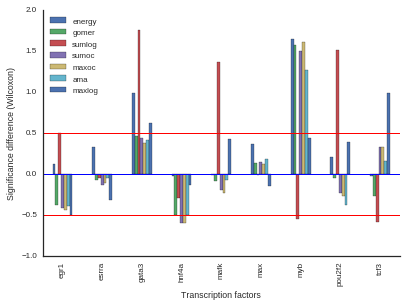

In [81]:
sns.set(style="white", context="paper")
test.T.plot.bar(stacked=False)
plt.axhline(0.5, linewidth=1, color='r')
plt.axhline(0, linewidth=1, color='b')
plt.axhline(-0.5, linewidth=1, color='r')
plt.ylabel("Significance difference (Wilcoxon)")
plt.xlabel("Transcription factors")
plt.legend(loc="upper left")
sns.despine()
plt.savefig("%s/effect_of_data_cohens_auc.pdf" % (figure_path), bbox_inches='tight')